## 1. Classes

In [1]:
from pydantic import BaseModel, Field
from typing import Optional
import torch
import torch.optim as optim
import torch.nn as nn
import pytorch_lightning as pl


class TrainingParameters(BaseModel):
    latent_dim: int = Field(description='latent space dimension')
    shuffle: bool = Field(description='shuffle data')
    batch_size: int = Field(description= 'batch size')
    num_epochs: int = Field(description='number of epochs')
    base_channel_size: int = Field(description='number of base channels')
    validation_ok: bool = Field(description='include validation')
    seed: Optional[int] = Field(description='random seed')


class TestingParameters(BaseModel):
    batch_size: int = Field(description='batch size')
    num_clusters: int = Field(description='number of clusters')

        
class EvaluationParameters(BaseModel):
    batch_size: int = Field(description='batch size')
    max_clusters: int = Field(description='maximum number of clusters')


class Encoder(nn.Module):
    def __init__(self,
                 num_input_channels: int,
                 base_channel_size: int,
                 width: int,
                 height: int,
                 latent_dim: int,
                 act_fn: object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - width, height: Dimensionality of the input image
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        linear_dim = int(width*height / 64)
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),  # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 8x8 => 4x4
            act_fn(),
            nn.Flatten(),  # Image grid to single feature vector
            nn.Linear(2 * linear_dim * c_hid, latent_dim)
        )

    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self,
                 num_input_channels: int,
                 base_channel_size: int,
                 width: int,
                 height: int,
                 latent_dim: int,
                 act_fn: object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - width, height: Dimensionality of the input image
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        self.width = width
        self.height = height
        c_hid = base_channel_size
        linear_dim = int(width*height / 64)
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2 * linear_dim * c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh()  # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, int(self.width/8), int(self.height/8))
        x = self.net(x)
        return x


class Autoencoder(pl.LightningModule):
    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class: object = Encoder,
                 decoder_class: object = Decoder,
                 num_input_channels: int = 1,
                 width: int = 32,
                 height: int = 32):
        super().__init__()
        self.train_loss = 0
        self.validation_loss = 0
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, width, height, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, width, height, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, _ = batch  # We do not need the labels
        x_hat = self.forward(x)
        loss = torch.nn.functional.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
        #                                                  mode='min',
        #                                                  factor=0.2,
        #                                                  patience=20,
        #                                                  min_lr=5e-5)
        return {"optimizer": optimizer} #, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss, on_epoch=True)
        self.train_loss += float(loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss, on_epoch=True)
        self.validation_loss += float(loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss, on_epoch=True)

    def on_train_epoch_end(self):
        current_epoch = self.current_epoch
        num_batches = self.trainer.num_training_batches
        train_loss = self.train_loss
        self.train_loss = 0
        print('\n', current_epoch, ' ', train_loss / num_batches, end = '', flush=True)

    def on_validation_epoch_end(self):
        num_batches = self.trainer.num_val_batches # may be a list[int]
        validation_loss = self.validation_loss
        self.validation_loss = 0
        print(' ', validation_loss / num_batches, end = '', flush=True)

    def on_train_end(self):
        print('\nTrain process completed', flush=True)


## 2. Functions

In [2]:
import glob
import os

from PIL import Image
import numpy as np
import torch
from torchvision import datasets, transforms


def get_dataloaders(data_path, batch_size, shuffle, num_workers, set):
    '''
    This function creates the dataloaders in PyTorch from directory or npy files
    Args:
        data_path:      [str] Path to data
        batch_size:     [int] Batch size
        shuffle:        [bool] Shuffle data
        num_workers:    [int] Number of workers
        set:            [str] Set to load: train, val, or test
    Returns:
        PyTorch DataLoaders
    '''
    data_type = os.path.splitext(data_path)[-1]
    if data_type == '.npz':
        # read from numpy array
        with np.load(data_path, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII') as file:
            data = np.array(file[set])
        # check if grayscale
        if len(data.shape) == 2:
            data = data[:, np.newaxis]
        dataset = torch.tensor(data)
    else:
        first_data = glob.glob(data_path + '/**/*.*', recursive=True)
        data_type = os.path.splitext(first_data[0])[-1]

        if data_type in ['.tiff', '.tif', '.jpg', '.jpeg', '.png']:
            img = Image.open(first_data[-1])
            transform = transforms.Compose([# transforms.Resize([256, 256]),
                                            # transforms.RandomCrop(224),
                                            # transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor()])
            dataset = datasets.ImageFolder(root=data_path, transform=transform)
        else:
            dataset = []

    dataset = dataset.transpose(1, 3)
    (input_channels, width, height) = dataset.shape[1:]
    dataloader = torch.utils.data.DataLoader([[dataset[i], dataset[i]] for i in range(len(dataset))],
                                             shuffle=shuffle,
                                             batch_size=batch_size,
                                             num_workers=num_workers)
    return dataloader, (width, height)


def embed_imgs(model, data_loader):
    embed_list = []
    for counter, imgs in enumerate(data_loader):
        with torch.no_grad():
            z = model.encoder(imgs[0].to(model.device))
        embed_list.append(z)
    return torch.cat(embed_list, dim=0)


def split_dataset(dataset, data_split):
    '''
    This function splits the input dataset according to the splitting ratios
    Args:
        dataset:            Full dataset to be split
        data_split:         List of split ratios according to the following:
                                Case 1: [training_ratio] --> split dataset for training and testing only
                                Case 2: [training_ratio, validation_ratio] --> include validation
                            where 0<ratio<1
    Returns:
        train_set:          Training torch subset
        test_set:           Testing torch subset
        Optional[val_set]:  Validation torch subset
    '''
    train_split = data_split[0]
    data_size = dataset.shape[0]
    train_size = int(train_split * data_size)
    if len(data_split) == 1:
        # Split data for training and testing
        train_set, test_set = torch.utils.data.random_split(dataset, [train_size, data_size - train_size])
        train_set.indices
        return train_set, test_set
    else:
        # Split data for training, validation, and testing
        val_split = data_split[1]
        val_size = int(val_split * data_size)
        train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size,
                                                                               data_size - train_size - val_size])
        return train_set, val_set, test_set


## 3. Training

In [8]:
import argparse
import json

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torch


SEED = 42
NUM_WORKERS = 0
INPUT_DIR = '/data/tanchavez/Datasets/scattering/mixed_small_32x32.npz'
OUTPUT_DIR = 'classification_train_32x32'

train_parameters = TrainingParameters(
    latent_dim= 16,
    shuffle= True,
    batch_size= 32,
    num_epochs= 100,
    base_channel_size= 32,
    validation_ok = False)

if train_parameters.seed:
    seed = train_parameters.seed    # Setting the user-defined seed
else:
    seed = SEED                     # Setting the pre-defined seed
pl.seed_everything(seed)
print("Seed: ", seed)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

train_loader, (width, height) = get_dataloaders(INPUT_DIR,
                                                train_parameters.batch_size,
                                                train_parameters.shuffle,
                                                NUM_WORKERS,
                                                'x_train')

val_loader = []
if train_parameters.validation_ok:
    val_loader, (temp_w, temp_h) = get_dataloaders(INPUT_DIR,
                                                   train_parameters.batch_size,
                                                   train_parameters.shuffle,
                                                   NUM_WORKERS,
                                                   'x_val')

trainer = pl.Trainer(default_root_dir=OUTPUT_DIR,
                     gpus=1 if str(device).startswith("cuda") else 0,
                     max_epochs=train_parameters.num_epochs,
                     progress_bar_refresh_rate=0,
                     callbacks=[ModelCheckpoint(dirpath = OUTPUT_DIR,
                                                filename='checkpoint_file.ckpt',
                                                save_weights_only=True)])   #disable progress bar
trainer.logger._log_graph = False           # If True, we plot the computation graph in tensorboard
trainer.logger._default_hp_metric = None    # Optional logging argument that we don't need

model = Autoencoder(base_channel_size=train_parameters.base_channel_size,
                    latent_dim=train_parameters.latent_dim,
                    width=width,
                    height=height)

trainer.fit(model, train_loader, val_loader)

Global seed set to 42


Seed:  42
Device: cuda:0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 118 K  | [2, 1, 32, 32] | [2, 16]       
1 | decoder | Decoder | 119 K  | [2, 16]        | [2, 1, 32, 32]
----------------------------------------------------------------------
237 K     Trainable params
0         Non-trainable params
237 K     Total params
0.950     Total estimated model params size (MB)
/home/tanchavez/anaconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /data/tanchavez/Local_scripts/unsup_classifier/classification_train exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Global seed set to 42



 0   2.494451888096289
 1   0.5255435894377924
 2   0.37779058471757926
 3   0.2840017867589564
 4   0.2505016267108961
 5   0.208863446243802
 6   0.18906335537092014
 7   0.17515176501281737
 8   0.1558156193726078
 9   0.1508702678364145
 10   0.14057584740630125
 11   0.13422710385677528
 12   0.1306282104583801
 13   0.12304676774807506
 14   0.11897152052746177
 15   0.11783452461417458
 16   0.11340115326277952
 17   0.1100126325120465
 18   0.10891350080349382
 19   0.10749448868709956
 20   0.10299111444033152
 21   0.10352770612665352
 22   0.09952504191057283
 23   0.09923087690924541
 24   0.09933131067950612
 25   0.09624987614717355
 26   0.0952164159519036
 27   0.09483597212738376
 28   0.09466240194607424
 29   0.09355438659154901
 30   0.0924398660373753
 31   0.0893807347516582
 32   0.09079847476314039
 33   0.09138135242206087
 34   0.08863407426890006
 35   0.08807232504509648
 36   0.08822794270001938
 37   0.08842489401038593
 38   0.08532739286285432
 39   0.0

## 4. Number of clusters with KMeans

In [37]:
import argparse
import json

from sklearn.cluster import KMeans
import torch

NUM_WORKERS = 0
INPUT_DIR = '/data/tanchavez/Datasets/scattering/mixed_small_32x32.npz'
MODEL_DIR = 'classification_train_32x32'
OUTPUT_DIR = 'classification_evaluation_32x32'

eval_parameters = EvaluationParameters(
    batch_size = 32,
    max_clusters = 20
)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

test_loader, (width, height) = get_dataloaders(INPUT_DIR,
                                               eval_parameters.batch_size,
                                               False,
                                               NUM_WORKERS,
                                               'x_test')

model1 = Autoencoder.load_from_checkpoint(MODEL_DIR+'/checkpoint_file.ckpt-v2.ckpt')
test_img_embeds = embed_imgs(model1, test_loader)        # test images in latent space
distortions = []
for k in range(2,eval_parameters.max_clusters+1):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(test_img_embeds.cpu().detach().numpy())
    print(kmeanModel.inertia_)
    distortions.append(kmeanModel.inertia_)

Device: cuda:0
102497.15625
81503.1484375
68449.1328125
62673.234375
59313.34765625
56507.625
54190.203125
51429.3359375
49665.1328125
47557.1875
45162.2109375
43222.44140625
42342.12109375
40530.86328125
38925.86328125
37326.48046875
36929.5625
35890.59765625
34667.80859375


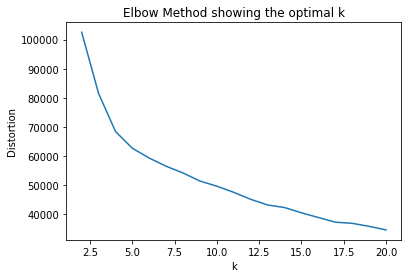

In [38]:
import matplotlib.pyplot as plt

plt.plot(list(range(2,eval_parameters.max_clusters+1)),distortions)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method showing the optimal k')
plt.show()

## 5. Prediction with KMeans

In [41]:
import argparse
import json

from sklearn.cluster import KMeans
import torch

NUM_WORKERS = 0
INPUT_DIR = '/data/tanchavez/Datasets/scattering/mixed_small_32x32.npz'
MODEL_DIR = 'classification_train_32x32'
OUTPUT_DIR = 'classification_evaluation_32x32'

test_parameters = TestingParameters(
    batch_size = 32,
    num_clusters = 5
)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

test_loader, (width, height) = get_dataloaders(INPUT_DIR,
                                               test_parameters.batch_size,
                                               False,
                                               NUM_WORKERS,
                                               'x_test')

model1 = Autoencoder.load_from_checkpoint(MODEL_DIR+'/checkpoint_file.ckpt-v2.ckpt')
test_img_embeds = embed_imgs(model1, test_loader)        # test images in latent space

kmeanModel = KMeans(n_clusters=test_parameters.num_clusters)
kmeanModel.fit(test_img_embeds.cpu().detach().numpy())
labels = kmeanModel.labels_

Device: cuda:0


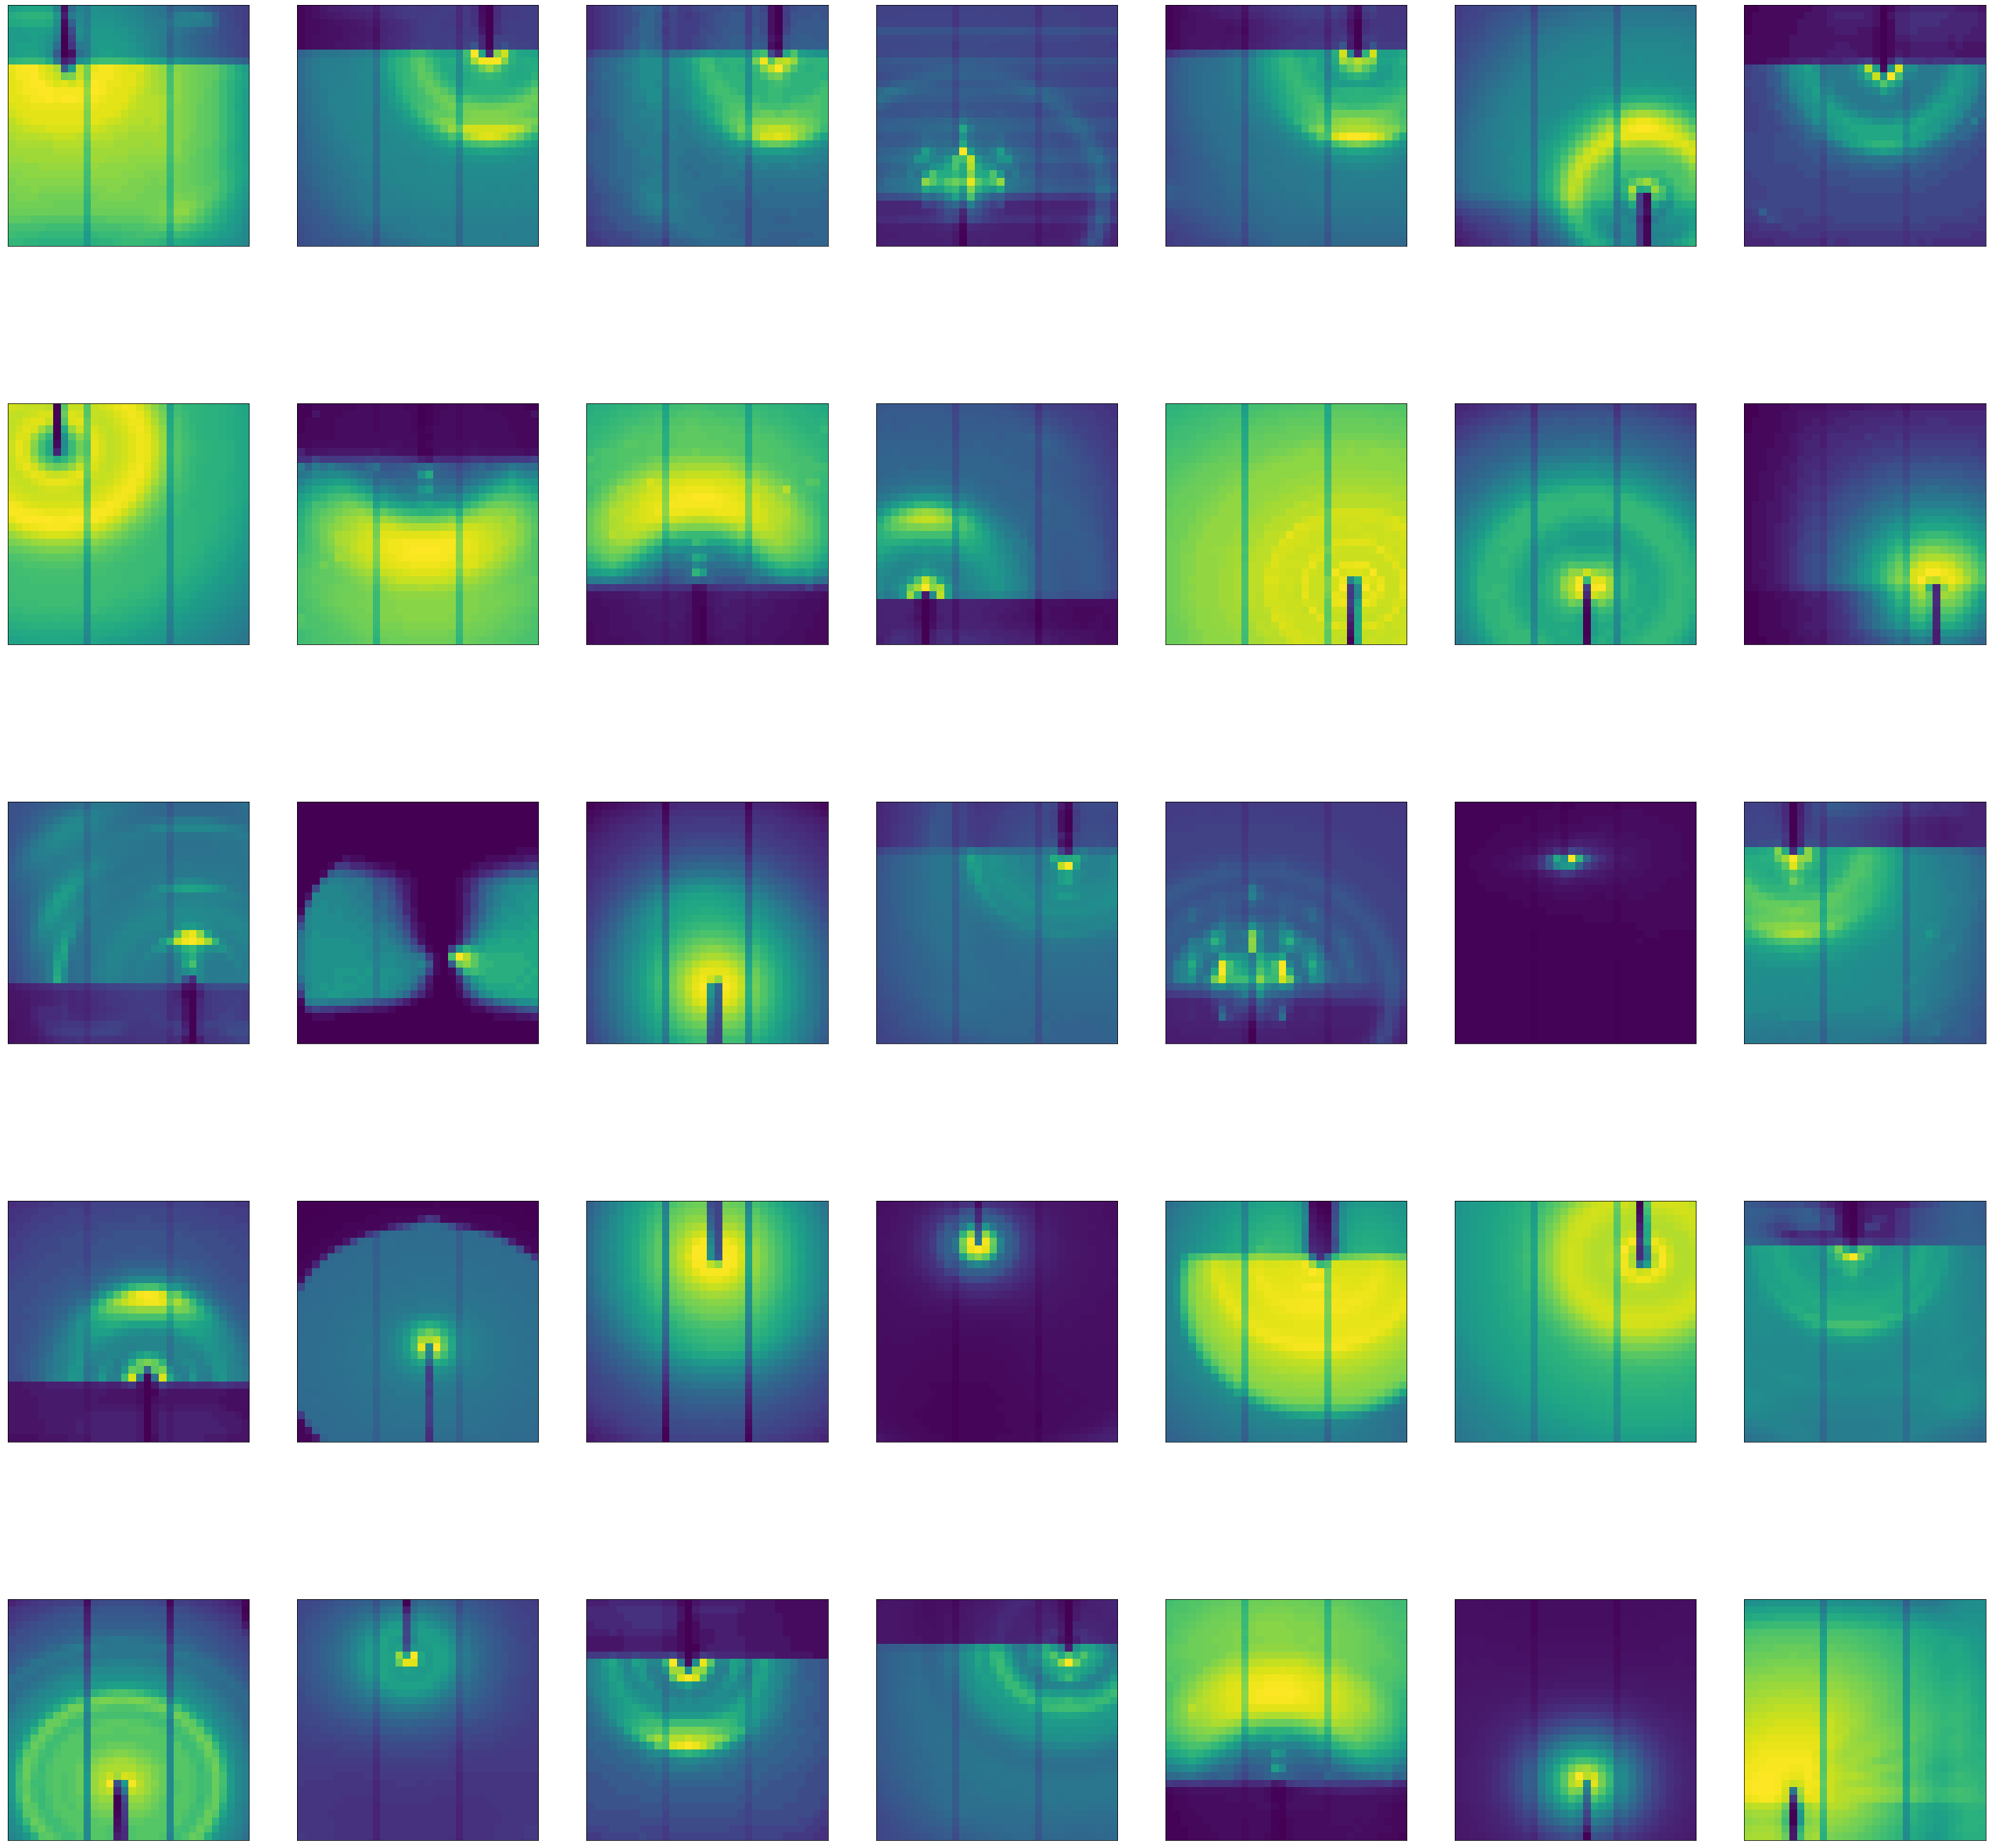

In [72]:
import random
import numpy as np

path = ('/data/tanchavez/Datasets/scattering/mixed_small_32x32.npz')   #read npz file with images
with np.load(path, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII') as data:
    test_data = data['x_test']
    
f, axarr = plt.subplots(test_parameters.num_clusters,7,figsize=(50, 50))
for row in range(test_parameters.num_clusters):
    imgs_in_cluster = np.where(labels==row)
    num_imgs = len(imgs_in_cluster[0])
    indx = random.sample(range(num_imgs), 7)
    for col in range(7):
        axarr[row,col].imshow(test_data[indx[col]])
        axarr[row,col].get_xaxis().set_visible(False)
        axarr[row,col].get_yaxis().set_visible(False)

plt.show()

## 6. Number of clusters with GMM

In [3]:
import argparse
import json

from sklearn import mixture
from sklearn.metrics import silhouette_score
import torch

NUM_WORKERS = 0
INPUT_DIR = '/data/tanchavez/Datasets/scattering/mixed_small_32x32.npz'
MODEL_DIR = 'classification_train_32x32'
OUTPUT_DIR = 'classification_evaluation_32x32'

eval_parameters = EvaluationParameters(
    batch_size = 32,
    max_clusters = 20
)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

test_loader, (width, height) = get_dataloaders(INPUT_DIR,
                                               eval_parameters.batch_size,
                                               False,
                                               NUM_WORKERS,
                                               'x_test')

model1 = Autoencoder.load_from_checkpoint(MODEL_DIR+'/checkpoint_file.ckpt-v2.ckpt')
test_img_embeds = embed_imgs(model1, test_loader)        # test images in latent space
distortions = []
for k in range(2,eval_parameters.max_clusters+1):
    model = mixture.GaussianMixture(n_components=k)
    preds = model.fit_predict(test_img_embeds.cpu().detach().numpy()) 
    score = silhouette_score(test_img_embeds.cpu().detach().numpy(), preds)
    print(score)
    distortions.append(score)

Device: cuda:0
0.19928655
0.03955277
0.00070234336
-0.004493034
0.0034472793
0.004412864
0.0578789
0.029225461
0.0630506
0.07337003
0.066330716
0.07470146
0.07576928
0.07261908
0.09157921
0.09035346
0.042619262
0.07948435
0.07601774


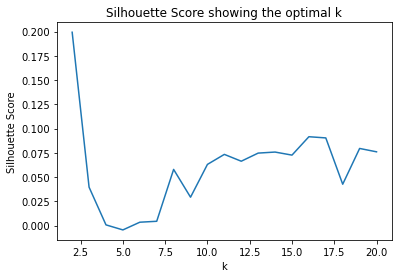

In [5]:
import matplotlib.pyplot as plt

plt.plot(list(range(2,eval_parameters.max_clusters+1)),distortions)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score showing the optimal k')
plt.show()

## 7. Prediction with GMM

In [118]:
import argparse
import json

from sklearn import mixture
import torch

NUM_WORKERS = 0
INPUT_DIR = '/data/tanchavez/Datasets/scattering/mixed_small_32x32.npz'
MODEL_DIR = 'classification_train'
OUTPUT_DIR = 'classification_evaluation'

test_parameters = TestingParameters(
    batch_size = 32,
    num_clusters = 6
)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

test_loader, (width, height) = get_dataloaders(INPUT_DIR,
                                               test_parameters.batch_size,
                                               False,
                                               NUM_WORKERS,
                                               'x_test')

model1 = Autoencoder.load_from_checkpoint(MODEL_DIR+'/checkpoint_file.ckpt-v2.ckpt')
test_img_embeds = embed_imgs(model1, test_loader)        # test images in latent space

model = mixture.GaussianMixture(n_components=test_parameters.num_clusters)
model.fit(test_img_embeds) 
prob = model.predict_proba(test_img_embeds)

Device: cuda:0


In [119]:
labels = np.zeros((prob.shape[0],1))-1
for i in range(prob.shape[0]):
    label = np.where(prob[i,]>0.95)
    if len(label[0]) == 1:
        labels[i] = label[0]

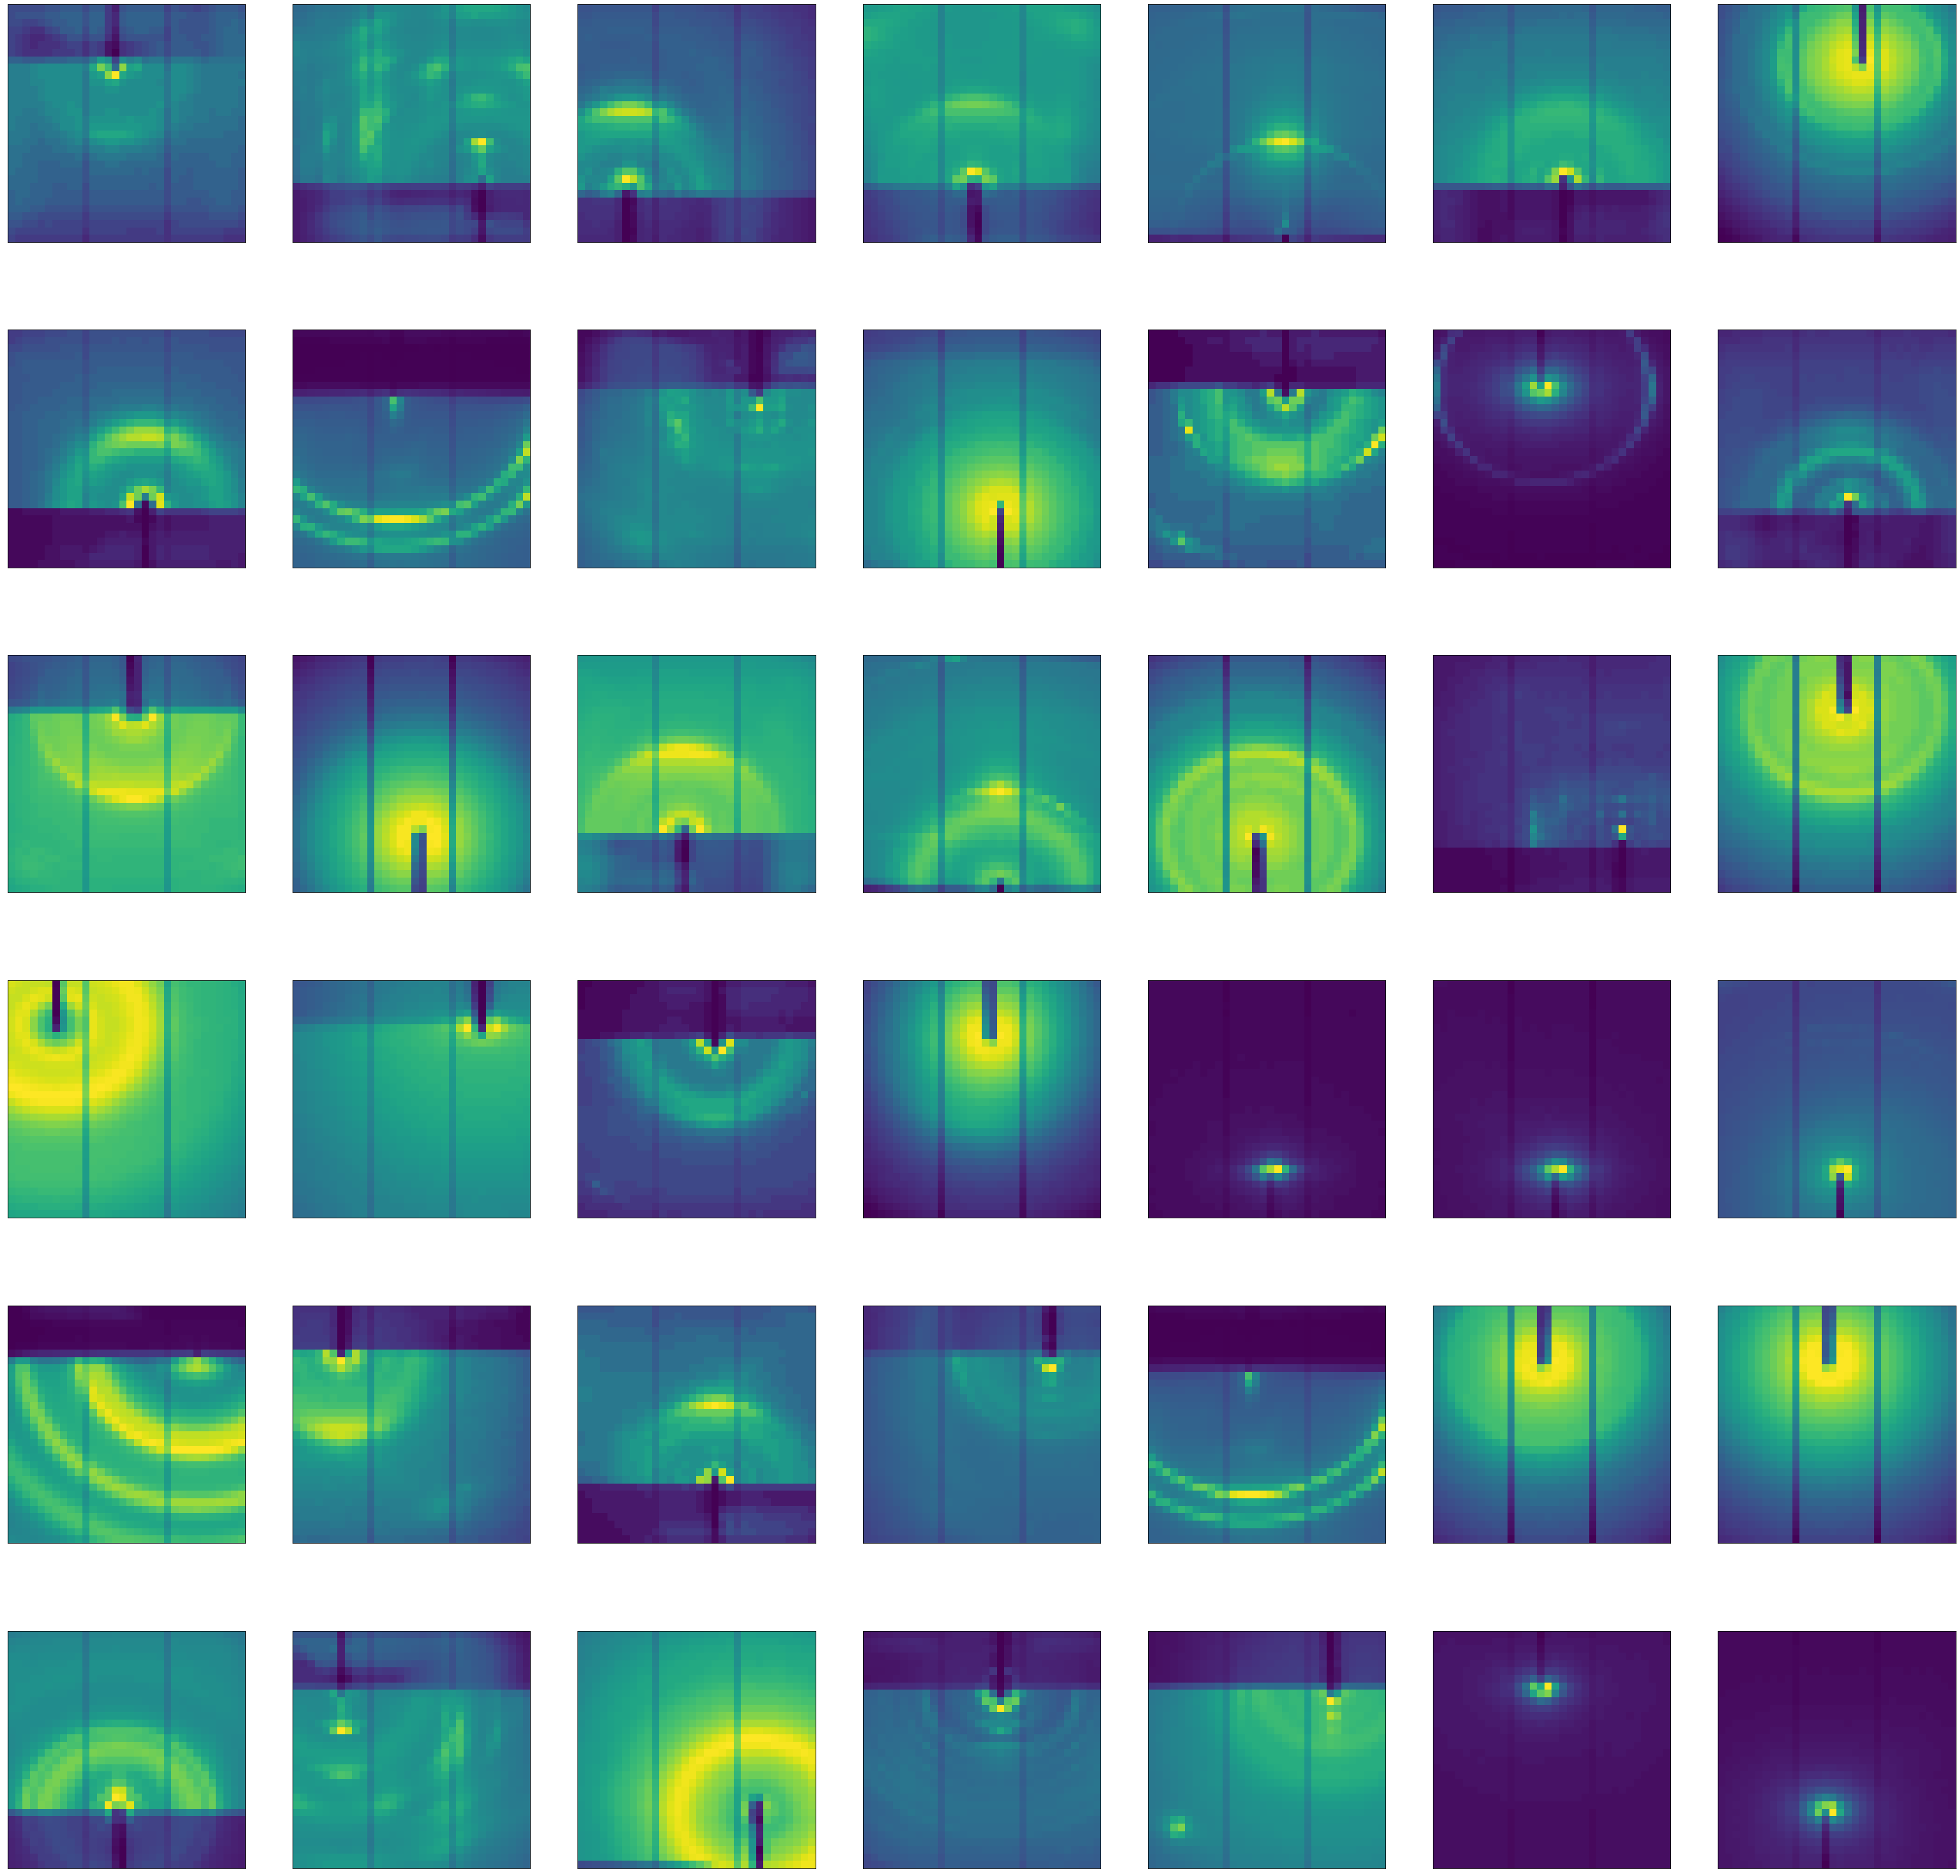

In [120]:
import random
import numpy as np

path = ('/data/tanchavez/Datasets/scattering/mixed_small_32x32.npz')   #read npz file with images
with np.load(path, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII') as data:
    test_data = data['x_test']
    
f, axarr = plt.subplots(test_parameters.num_clusters,7,figsize=(50, 50))
for row in range(test_parameters.num_clusters):
    imgs_in_cluster = np.where(labels==row)
    num_imgs = len(imgs_in_cluster[0])
    indx = random.sample(range(num_imgs), 7)
    for col in range(7):
        axarr[row,col].imshow(test_data[indx[col]])
        axarr[row,col].get_xaxis().set_visible(False)
        axarr[row,col].get_yaxis().set_visible(False)

plt.show()

## 8. Sanity check

In [6]:
def find_similar_images(query_img, query_z, key_embeds, K=12):
    # Find closest K images. We use the euclidean distance here but other like cosine distance can also be used.
    dist = torch.cdist(query_z[None,:], key_embeds[1], p=2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)
    # Plot K closest images
    imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:K]]], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12,3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [7]:
def embed_imgs2(model, data_loader):
    embed_list = []
    img_list = []
    for counter, imgs in enumerate(data_loader):
        with torch.no_grad():
            z = model.encoder(imgs[0].to(model.device))
        embed_list.append(z)
        img_list.append(imgs[0])
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))

In [12]:
train_img_embeds = embed_imgs2(model1, train_loader)
test_img_embeds = embed_imgs2(model1, test_loader)

/home/tanchavez/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


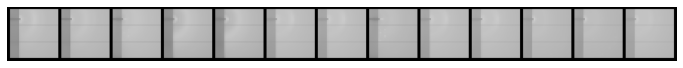

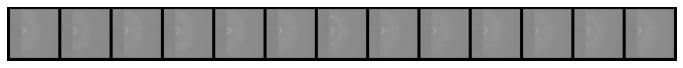

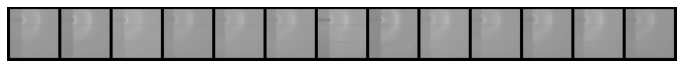

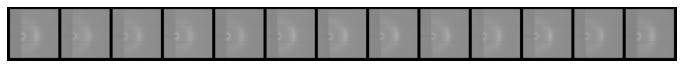

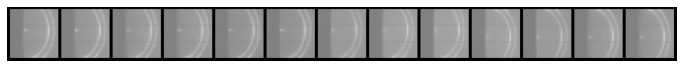

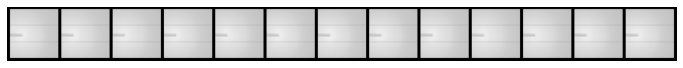

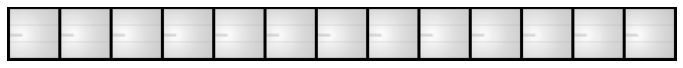

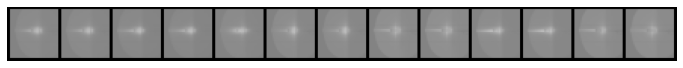

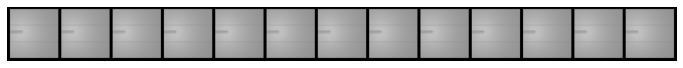

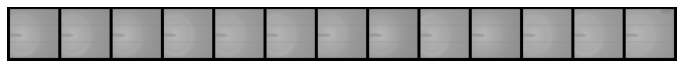

In [13]:
import torchvision
# Plot the closest images for the first N test images as example
for i in range(10):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds=train_img_embeds)